In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


RuntimeError: operator torchvision::nms does not exist

In [ ]:
# Load Fashion MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), ifi])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)


# Split train dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
class FashionMNIST_NN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(FashionMNIST_NN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the image to a vector
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # Output layer (logits)
        return x


In [ ]:
def initialize_weights(model, method='he'):
    for layer in model.children(): ,
        if isinstance(layer, nn.Linear):
            if method == 'xavier':
                nn.init.xavier_uniform_(layer.weight)
            elif method == 'he':
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), f'checkpoint_{val_loss}.pth')

In [ ]:
def train_model(l1_lambda=0, l2_lambda=0.01, dropout_rate=0.5, weight_init='he'):
    model = FashionMNIST_NN(dropout_rate)
    initialize_weights(model, weight_init)

    # Define optimizer with L2 regularization (weight decay)
    optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=l2_lambda)
    criterion = nn.CrossEntropyLoss()

    early_stopping = EarlyStopping(patience=5)

    num_epochs = 50
    train_losses = []
    val_losses = []


    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Apply L1 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    return model, train_losses, val_losses


In [ ]:
# Test model performance
def test_model(model):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds)
            all_labels.append(labels)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    test_acc = accuracy_score(all_labels.cpu(), all_preds.cpu())
    print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:
# Plotting the losses
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


Epoch 1, Train Loss: 114.8870, Val Loss: 0.8807
Epoch 2, Train Loss: 97.0274, Val Loss: 0.7650
Epoch 3, Train Loss: 81.1138, Val Loss: 0.7431
Epoch 4, Train Loss: 66.8422, Val Loss: 0.7543
Epoch 5, Train Loss: 54.1900, Val Loss: 0.7870
Epoch 6, Train Loss: 43.1628, Val Loss: 0.8384
Epoch 7, Train Loss: 33.7518, Val Loss: 0.9082
Epoch 8, Train Loss: 25.9731, Val Loss: 1.0066
Early stopping


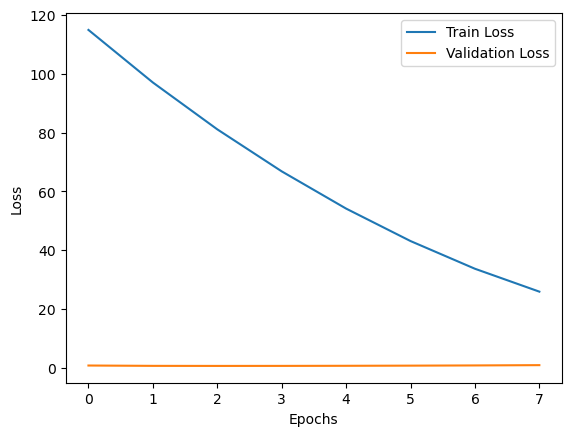

Test Accuracy: 0.7512


In [ ]:
# Running the experiment
l1_lambda = 0.01  # L1 regularization strength
l2_lambda = 0.01  # L2 regularization strength
dropout_rate = 0.0  # Dropout probability
weight_init = 'he'  # Weight initialization method (he or xavier)

model, train_losses, val_losses = train_model(l1_lambda=l1_lambda, l2_lambda=l2_lambda, dropout_rate=dropout_rate, weight_init=weight_init)

# Plot the losses
plot_losses(train_losses, val_losses)

# Test the model
test_model(model)

# Hyperparameter Tuning

In [ ]:
import random
from itertools import product

# Hyperparameter search space
param_grid = {
    'lr': [0.001, 0.0001, 0.01],              # Learning rates to test
    'dropout_rate': [0.3, 0.5, 0.7],          # Different dropout rates to test
    'l1_lambda': [0.0, 0.001, 0.01],          # Different L1 regularization strengths
    'l2_lambda': [0.0, 0.001, 0.01],          # Different L2 regularization strengths
    'weight_init': ['xavier', 'he']           # Different weight initialization methods
}

# Perform grid search
def grid_search():
    best_val_loss = float('inf')
    best_params = None
    best_model = None

    # Get all possible combinations of hyperparameters using Cartesian product
    param_combinations = list(product(*param_grid.values()))
    print(len(param_combinations))

    for i, combination in enumerate(param_combinations):
        params = dict(zip(param_grid.keys(), combination))
        print(f"Testing combination {i + 1}/{len(param_combinations)}: {params}")

        # Train the model with the current combination of hyperparameters
        model, train_losses, val_losses = train_model(l1_lambda=params['l1_lambda'],
                                                      l2_lambda=params['l2_lambda'],
                                                      dropout_rate=params['dropout_rate'],
                                                      weight_init=params['weight_init'])

        # Check the last validation loss
        val_loss = val_losses[-1]
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = params
            best_model = model
            print(f"New best validation loss: {best_val_loss:.4f}")

    return best_model, best_params

# Run the random search for the best hyperparameters
best_model_grid, best_params_grid = grid_search()
print("Best Hyperparameters found by Grid Search:")
print(best_params_grid)

print("Testing model from Grid Search:")
test_model(best_model_grid)

162
Testing combination 1/162: {'lr': 0.001, 'dropout_rate': 0.3, 'l1_lambda': 0.0, 'l2_lambda': 0.0, 'weight_init': 'xavier'}
Epoch 1, Train Loss: 1.9343, Val Loss: 1.3335
Epoch 2, Train Loss: 1.3259, Val Loss: 0.9404
Epoch 3, Train Loss: 1.0793, Val Loss: 0.7918
Epoch 4, Train Loss: 0.9556, Val Loss: 0.7199
Epoch 5, Train Loss: 0.8772, Val Loss: 0.6742


KeyboardInterrupt: 

In [ ]:
# Hyperparameter search space
param_grid = {
    'lr': [0.001, 0.0001, 0.01],              # Learning rates
    'dropout_rate': [0.3, 0.5, 0.7],          # Different dropout rates
    'l1_lambda': [0.0, 0.001, 0.01],          # Different L1 regularization strengths
    'l2_lambda': [0.0, 0.001, 0.01],          # Different L2 regularization strengths
    'weight_init': ['xavier', 'he', 'random_normal']           # Different weight initialization methods
}

def random_search(n_iter=10):
    best_val_loss = float('inf')
    best_params = None
    best_model = None

    # Generate random combinations of hyperparameters for n_iter iterations
    for i in range(n_iter):
        # Randomly select a combination of hyperparameters
        params = {
            'lr': random.choice(param_grid['lr']),
            'dropout_rate': random.choice(param_grid['dropout_rate']),
            'l1_lambda': random.choice(param_grid['l1_lambda']),
            'l2_lambda': random.choice(param_grid['l2_lambda']),
            'weight_init': random.choice(param_grid['weight_init'])
        }
        print(f"Testing combination {i + 1}/{n_iter}: {params}")

        # Train the model with the current combination of hyperparameters
        model, train_losses, val_losses = train_model(l1_lambda=params['l1_lambda'],
                                                      l2_lambda=params['l2_lambda'],
                                                      dropout_rate=params['dropout_rate'],
                                                      weight_init=params['weight_init'])

        # Check the last validation loss
        val_loss = val_losses[-1]
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = params
            best_model = model
            print(f"New best validation loss: {best_val_loss:.4f}")

    return best_model, best_params

# Run the random search for the best hyperparameters
best_model_random, best_params_random = random_search(n_iter=10)  # Specify the number of random trials
print("Best Hyperparameters found by Random Search:")
print(best_params_random)

print("Testing model from Random Search:")
test_model(best_model_random)

Testing combination 1/10: {'lr': 0.0001, 'dropout_rate': 0.3, 'l1_lambda': 0.0, 'l2_lambda': 0.001, 'weight_init': 'random_normal'}
Epoch 1, Train Loss: 2.2889, Val Loss: 2.2631
Epoch 2, Train Loss: 2.2442, Val Loss: 2.1971


KeyboardInterrupt: 